In [2]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

In [3]:
#Only run this cell if needed, comment this cell out if and only if Martin is an Ahole. (I still hate you for commenting it out last time). 
from dotenv import load_dotenv
import os

load_dotenv("../dotenv_env/deep_learning.env")

print(os.environ.get("HSA_OVERRIDE_GFX_VERSION"))

10.3.0


In [4]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


# Data preparation

## Data loading

In [5]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

In [6]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

In [ ]:
df_RV_ts.pivot(index="row_id",columns=["sub_int_num"],values=["sub_int_RV"])

In [7]:
RV_tab=pd.read_csv("../processed_data/RV_by_row_id.csv")
RV_tab["stock_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[0])
RV_tab["time_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[1])
RV_tab

,row_id,RV,stock_id,time_id
0,0-5,0.004499,0,5
1,0-11,0.001204,0,11
2,0-16,0.002369,0,16
3,0-31,0.002574,0,31
4,0-62,0.001894,0,62
...,...,...,...,...
428927,99-32751,0.001436,99,32751
428928,99-32753,0.001795,99,32753
428929,99-32758,0.001658,99,32758
428930,99-32763,0.002213,99,32763


In [8]:
# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(RV_tab['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
RV_tab['emb_id'] = RV_tab['stock_id'].map(id_to_emb)
RV_tab

,row_id,RV,stock_id,time_id,emb_id
0,0-5,0.004499,0,5,0
1,0-11,0.001204,0,11,0
2,0-16,0.002369,0,16,0
3,0-31,0.002574,0,31,0
4,0-62,0.001894,0,62,0
...,...,...,...,...,...
428927,99-32751,0.001436,99,32751,111
428928,99-32753,0.001795,99,32753,111
428929,99-32758,0.001658,99,32758,111
428930,99-32763,0.002213,99,32763,111


In [9]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


## Dataset creation

In [10]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



In [11]:
train_dataset.featureplace

{'sub_int_RV': (0, 60), 'emb_id': (60, 61)}

In [221]:
# Let's just see that our data looks correct:
train_dataset[20000]

(tensor([4.6594e-04, 1.5794e-04, 2.6052e-04, 2.0006e-04, 4.6036e-04, 4.1584e-04,
         9.8932e-04, 4.7264e-04, 2.1441e-04, 2.9363e-05, 2.4447e-04, 2.9892e-04,
         7.5965e-04, 6.9540e-04, 6.2064e-05, 9.8745e-04, 1.1972e-03, 5.2220e-04,
         1.2480e-04, 3.2021e-04, 2.0767e-04, 2.9159e-04, 1.3637e-04, 5.0568e-04,
         7.6126e-04, 5.4608e-05, 5.1065e-04, 5.1155e-04, 1.2982e-04, 1.5398e-04,
         6.1349e-04, 8.6339e-04, 4.7770e-04, 6.8327e-04, 5.8174e-04, 1.9467e-05,
         2.8003e-04, 3.1872e-04, 6.9253e-04, 8.4858e-05, 5.5608e-04, 1.2923e-03,
         7.3301e-04, 3.3100e-04, 3.8636e-04, 1.3472e-04, 4.8604e-04, 2.2667e-04,
         5.7036e-04, 2.3896e-04, 6.0563e-04, 2.2564e-04, 4.4306e-04, 1.6629e-04,
         2.7551e-04, 3.5369e-04, 3.3014e-04, 4.8192e-04, 5.2923e-04, 3.0226e-04,
         9.0000e+01]),
 tensor([0.0053]))

In [222]:
train_dataset.get_row_id(20000)

'102-4084'

In [223]:
# The assigned 'emb_id' looks good. This should be the same as the last element of the first tensor.
id_to_emb.get(102)

90

In [224]:
# Target looks good too
df_target[df_target["row_id"]=="102-4084"]

,stock_id,time_id,target,row_id
345167,102,4084,0.005318,102-4084


# The method of "Making the category part of the timeseries"

In this method, a learned embeding will embed the categorical_id (emb_id to be precise) in to a (normally 8) dim vector, which is then pre-appended to the front of the actual timeseries. 

# Model and plotting function

## A little bit of Pytorch

This part is just to understand how pytorch 'expand' works (needed to transform embeddings into time series to be passed to the RNN). The first (rows) and second (columns) dimensions of 'ref_tensor' play the roles of emb_id and stock_emb_dim respectively.

In [225]:
# The tensor is unrelated to anything. This part is just to illustrate how Pytorch works
row_indices = torch.arange(1,4).unsqueeze(1)
column_indices = torch.arange(1,5).unsqueeze(0)
ref_tensor = row_indices*column_indices
ref_tensor

tensor([[ 1,  2,  3,  4],
        [ 2,  4,  6,  8],
        [ 3,  6,  9, 12]])

The new middle dimension (rows) correspond to the length of our time series. We can think of columns as constant time series, given by the embedding of 'emb_id'. This example would correspond to having only 3 different stocks embedded in 4 dimensions.

In [226]:
ref_tensor.unsqueeze(1).expand(-1,8,-1)

tensor([[[ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4]],

        [[ 2,  4,  6,  8],
         [ 2,  4,  6,  8],
         [ 2,  4,  6,  8],
         [ 2,  4,  6,  8],
         [ 2,  4,  6,  8],
         [ 2,  4,  6,  8],
         [ 2,  4,  6,  8],
         [ 2,  4,  6,  8]],

        [[ 3,  6,  9, 12],
         [ 3,  6,  9, 12],
         [ 3,  6,  9, 12],
         [ 3,  6,  9, 12],
         [ 3,  6,  9, 12],
         [ 3,  6,  9, 12],
         [ 3,  6,  9, 12],
         [ 3,  6,  9, 12]]])

In addition to the embedding, this model also offers control over h0, the initialization of the hidden layer. For more details about dimensions, the initialization of the hidden layer and how RNN is implemented, see https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html.

In [10]:
# TODO: The splitting of x, as of now, only works for this particular dataset, doing the splitting using the capabilites of RV_Dataset remains to be done.
# Maybe the dataset should have an internal variable that tells us how many differet stocks there are in order to pass that to this model directly....?
# Is there a way to reuse RV_RNN_conv in RV_RNN_conv to avoid code duplication?

class RV_RNN_conv_emb(nn.Module):        
    # 07/17/25 Created from previous RV_RNN_conv. The parts that are different are marked by #NEW
    # 07/20/2025 Adds h0_mode (initialization of hidden layer)
    # NEW n_stocks, stock_emb_dim, h0_mode
    def __init__(self,n_diff,rnn_num_layer,rnn_drop_out,rnn_type="rnn",rnn_act="tanh",proj_dim=32,rnn_hidden_size=32,input_scaler=10000, n_stocks=112, stock_emb_dim=8, h0_mode="zero"):
        """
        :param n_diff: Decides how many derivative features is wanted in the time series. 
        :param rnn_num_layer: num_layer parameter for rnn. 
        :param rnn_drop_out: dropout parameter for rnn. 
        :param rnn_act: Defaulted to "tanh". Nonlinearity parameter for rnn. 
        :param proj_dim: Defaulted to 32. Decided the dimension of projection before feeding into rnn. 
        :param rnn_hidden_size: Defaulted to 32. The hidden_size parameter for rnn. 
        :param input_scaler: Defaulted to 10000. Set a scaling to input, a lot of timeseries values of our data are extremely close to zero. 
        :param rnn_type: 'rnn', 'lstm', or 'gru'
        :param n_stocks: The number of different stocks considered
        :param stock_emb_dim: The dimension of the embedding
        :param h0_mode: Determines h0, the initialization for the hidden layer. "zero": sets h0 to zero (standard behavior of Pytorch's RNN), 
                        "random": uses random initialization, "learned": uses a learned projection based on the embedding  
        """
        super().__init__()
        
        self.input_scaler=input_scaler
        self.frozen_conv=training.frozen_diff_conv(n_diff=n_diff)
        self.linear_proj_input=nn.Linear(n_diff+1,proj_dim)

        self.rnn_type = rnn_type

        # NEW
        self.stock_embedding = nn.Embedding(num_embeddings=n_stocks, embedding_dim=stock_emb_dim) # NEW
        rnn_input_size = proj_dim + stock_emb_dim #NEW

        # 07/20/2025 Adds necessary variables for changing h0
        self.h0_mode = h0_mode
        self.rnn_num_layer = rnn_num_layer
        self.rnn_hidden_size = rnn_hidden_size

        # 07/20/025 Adds necessary variables for changing h0
        if h0_mode == "learned":
            self.h0_proj = nn.Linear(stock_emb_dim, rnn_hidden_size)
        else:
            self.h0_proj = None
        
        if rnn_type == "rnn":
            # CHANGED rnn_input_size
            self.RNN_layer=nn.RNN(input_size=rnn_input_size,
                                  hidden_size=rnn_hidden_size,
                                  num_layers=rnn_num_layer,
                                  nonlinearity=rnn_act,
                                  batch_first=True,
                                  dropout=rnn_drop_out)
        elif rnn_type == "lstm":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='lstm'")
            # CHANGED rnn_input_size
            self.RNN_layer = nn.LSTM(input_size=rnn_input_size,
                                     hidden_size=rnn_hidden_size,
                                     num_layers=rnn_num_layer,
                                     batch_first=True,
                                     dropout=rnn_drop_out)
        elif rnn_type == "gru":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='gru'")
            # CHANGED rnn_input_size
            self.RNN_layer = nn.GRU(input_size=rnn_input_size,
                                    hidden_size=rnn_hidden_size,
                                    num_layers=rnn_num_layer,
                                    batch_first=True,
                                    dropout=rnn_drop_out)
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")
        
        self.linear_post_rnn=nn.Linear(rnn_hidden_size,1)
        self.frozen_list=["frozen_conv"] 
        
    def forward(self,x):
        # NEW
        # Expected shape of x before splitting: (N, L + 1), where N is the batch number
        x, emb_id = x[:, :-1], x[:, -1].long() # (N,L) and (N,) respectively  # NEW
        
        #First, scale the input, and unsqueese to add in one dimension in dim 1 as channel. This is needed for convolution. 
        x*=self.input_scaler
        x=torch.unsqueeze(x,dim=1) # (N,1,L)
        x=self.frozen_conv(x) # (N, n_diff+1, L)
        x=x.permute(0,2,1) # (N, L, n_diff+1)
        x=self.linear_proj_input(x) # (N, L, proj_dim)

        # 07/20/2025
        N = x.shape[0]  # Batch size
        L = x.shape[1]  # Time series length

        stock_emb = self.stock_embedding(emb_id) # (N, stock_emb_dim) Do note that nn.Embedding directly maps one integer to a vector of dimension stock_emb_dim (in batches) # NEW
        stock_emb_exp = stock_emb.unsqueeze(1).expand(-1, L, -1) # (N, L, stock_emb_dim) # NEW
        x = torch.cat([x, stock_emb_exp], dim=-1) # (N, L, proj_dim + stock_emb_dim) # NEW
        
        # 07/20/2025 Adds diffferent initializations for h0
        device = x.device
        if self.h0_mode == "zero":
            h0 = torch.zeros(self.rnn_num_layer, N, self.rnn_hidden_size, device=device) # (num_layer, N, hidden_size)
        elif self.h0_mode == "random":
            h0 = torch.randn(self.rnn_num_layer, N, self.rnn_hidden_size, device=device) # (num_layer, N, hidden_size)
        elif self.h0_mode == "learned":
            h0 = self.h0_proj(stock_emb)
            h0 = h0.unsqueeze(0).expand(self.rnn_num_layer, -1, -1) # (num_layer, N, hidden_size)
        else:
            raise ValueError(f"Unsupported h0_mode: {self.h0_mode}")

        # 07/20/2025 LSTM needs to initial states h0 and c0 so it is handled a bit different
        if self.rnn_type == "lstm":
            # LSTM requires also c0. It is set to zero for simplicity
            c0 = torch.zeros(self.rnn_num_layer, N, self.rnn_hidden_size, device=device) # (num_layer, N, hidden_size)
            x, _ = self.RNN_layer(x, (h0, c0))
        else:
            x, _ = self.RNN_layer(x, h0)
                     
        x=self.linear_post_rnn(x) # (N,L, 1)
        
        return torch.sum(x,dim=1)/self.input_scaler # (N, 1)

# Training

I left this part of the data handling here, because changing some of these parameters has an impact on training performance.

In [11]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

import torch.optim as optim

Let us try all the variants of our model (i.e. "rnn", "lstm", "gru") with the initialization of the hidden layer set to zeros.

## Pure RNN

At  4.865077972412109  epoch  1 has training loss  tensor(0.2761, device='cuda:0')  and validation loss  tensor(0.2353, device='cuda:0') .

At  22.94200611114502  epoch  5 has training loss  tensor(0.2465, device='cuda:0')  and validation loss  tensor(0.2308, device='cuda:0') .

At  46.009198904037476  epoch  10 has training loss  tensor(0.2449, device='cuda:0')  and validation loss  tensor(0.2268, device='cuda:0') .

At  69.15997743606567  epoch  15 has training loss  tensor(0.2444, device='cuda:0')  and validation loss  tensor(0.2274, device='cuda:0') .

At  92.74550747871399  epoch  20 has training loss  tensor(0.2434, device='cuda:0')  and validation loss  tensor(0.2269, device='cuda:0') .

At  116.01563429832458  epoch  25 has training loss  tensor(0.2434, device='cuda:0')  and validation loss  tensor(0.2273, device='cuda:0') .

The validation loss has not improved for  10  epochs. Stopping current training loop.

Best model state dictionary of this training loop is reloaded.

Acc

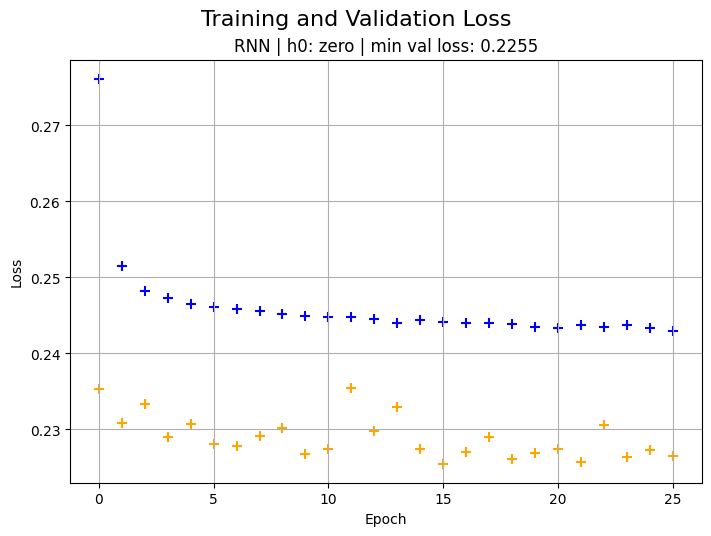

In [12]:
rnn_type="rnn"
h0_mode="zero"

RNN_emb_model=RV_RNN_conv_emb(n_diff=2, 
                              rnn_type=rnn_type,
                              rnn_act="tanh",
                              rnn_drop_out=0,
                              rnn_hidden_size=32,
                              proj_dim=32,
                              rnn_num_layer=1,
                              input_scaler=10000, 
                              stock_emb_dim=8,
                              h0_mode=h0_mode).to(device=device)

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,
                                 model=RNN_emb_model,
                                 train_loader=train_loader,
                                 val_loader=test_loader,
                                 list_train_loss=train_loss,
                                 list_val_loss=val_loss,
                                 device=device,
                                 n_epochs=100,
                                 ot_steps=10,
                                 report_interval=5,
                                 eps=0,scaler=1)

# For the plotting function we need to pass the runs to plot as a dictionary of dictionaries. The purpose of this is that it is easy to store 'train_loss' and 'val_loss'
# for many combinations of models and parameters in a clear way.
experiment = {(rnn_type, h0_mode):{"train_loss": train_loss, "val_loss": val_loss}}
visualization.training_plots(experiment, fig_width=7)

## LSTM

At  1.1346096992492676  epoch  1 has training loss  tensor(0.2694, device='cuda:0')  and validation loss  tensor(0.2332, device='cuda:0') .

At  6.599930286407471  epoch  5 has training loss  tensor(0.2435, device='cuda:0')  and validation loss  tensor(0.2277, device='cuda:0') .

At  13.388167142868042  epoch  10 has training loss  tensor(0.2410, device='cuda:0')  and validation loss  tensor(0.2243, device='cuda:0') .

At  20.22780680656433  epoch  15 has training loss  tensor(0.2391, device='cuda:0')  and validation loss  tensor(0.2243, device='cuda:0') .

At  27.02997660636902  epoch  20 has training loss  tensor(0.2383, device='cuda:0')  and validation loss  tensor(0.2236, device='cuda:0') .

At  33.88550353050232  epoch  25 has training loss  tensor(0.2376, device='cuda:0')  and validation loss  tensor(0.2244, device='cuda:0') .

At  40.6518828868866  epoch  30 has training loss  tensor(0.2370, device='cuda:0')  and validation loss  tensor(0.2238, device='cuda:0') .

At  47.5805318

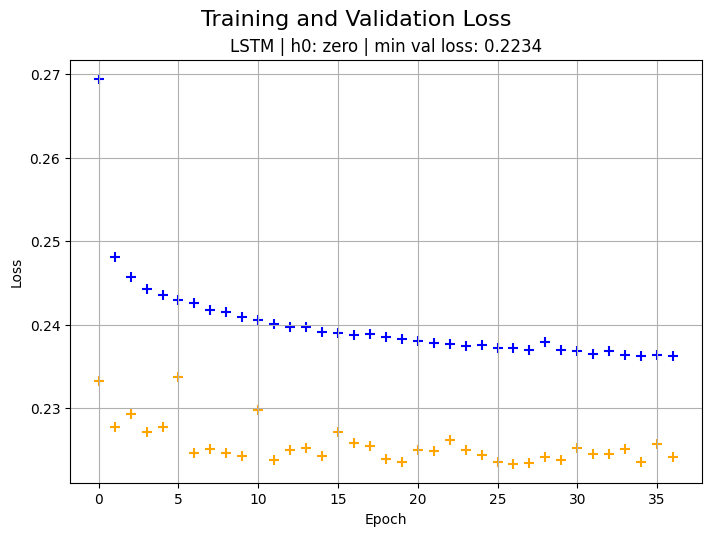

In [230]:
rnn_type="lstm"
h0_mode="zero"

RNN_emb_model=RV_RNN_conv_emb(n_diff=2, 
                              rnn_type=rnn_type,
                              rnn_act="tanh",
                              rnn_drop_out=0,
                              rnn_hidden_size=32,
                              proj_dim=32,
                              rnn_num_layer=1,
                              input_scaler=10000, 
                              stock_emb_dim=8,
                              h0_mode=h0_mode).to(device=device)

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,
                                 model=RNN_emb_model,
                                 train_loader=train_loader,
                                 val_loader=test_loader,
                                 list_train_loss=train_loss,
                                 list_val_loss=val_loss,
                                 device=device,
                                 n_epochs=100,
                                 ot_steps=10,
                                 report_interval=5,
                                 eps=0,scaler=1)

experiment = {(rnn_type, h0_mode):{"train_loss": train_loss, "val_loss": val_loss}}
visualization.training_plots(experiment, fig_width=7)

At  1.239532232284546  epoch  1 has training loss  tensor(0.2672, device='cuda:0')  and validation loss  tensor(0.2337, device='cuda:0') .

At  6.959047555923462  epoch  5 has training loss  tensor(0.2459, device='cuda:0')  and validation loss  tensor(0.2275, device='cuda:0') .

At  14.676267862319946  epoch  10 has training loss  tensor(0.2422, device='cuda:0')  and validation loss  tensor(0.2403, device='cuda:0') .

At  21.98938250541687  epoch  15 has training loss  tensor(0.2404, device='cuda:0')  and validation loss  tensor(0.2236, device='cuda:0') .

At  29.80687975883484  epoch  20 has training loss  tensor(0.2393, device='cuda:0')  and validation loss  tensor(0.2254, device='cuda:0') .

At  37.34498906135559  epoch  25 has training loss  tensor(0.2384, device='cuda:0')  and validation loss  tensor(0.2267, device='cuda:0') .

At  44.91791081428528  epoch  30 has training loss  tensor(0.2377, device='cuda:0')  and validation loss  tensor(0.2236, device='cuda:0') .

At  52.5807399

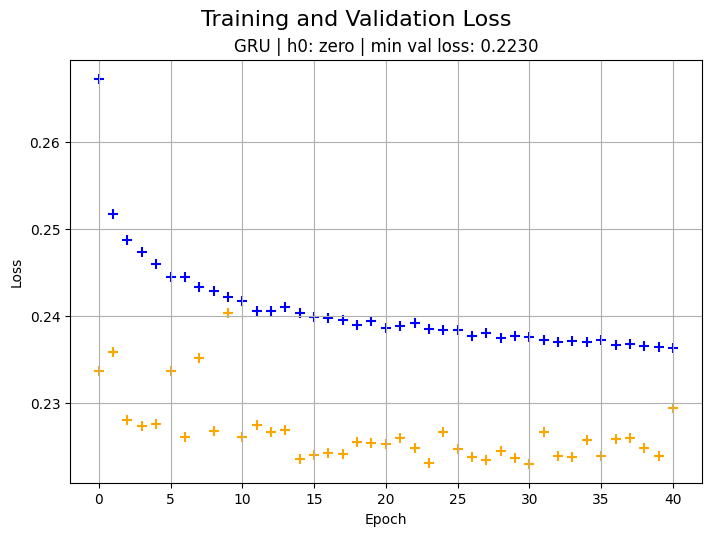

In [231]:
rnn_type="gru"
h0_mode="zero"

RNN_emb_model=RV_RNN_conv_emb(n_diff=2, 
                              rnn_type=rnn_type,
                              rnn_act="tanh",
                              rnn_drop_out=0,
                              rnn_hidden_size=32,
                              proj_dim=32,
                              rnn_num_layer=1,
                              input_scaler=10000, 
                              stock_emb_dim=8,
                              h0_mode=h0_mode).to(device=device)

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,
                                 model=RNN_emb_model,
                                 train_loader=train_loader,
                                 val_loader=test_loader,
                                 list_train_loss=train_loss,
                                 list_val_loss=val_loss,
                                 device=device,
                                 n_epochs=100,
                                 ot_steps=10,
                                 report_interval=5,
                                 eps=0,scaler=1)

experiment = {(rnn_type, h0_mode):{"train_loss": train_loss, "val_loss": val_loss}}
visualization.training_plots(experiment, fig_width=7)

# All combinations

Let's run all the variants of our model (rnn_type = 'rnn', 'lstm', 'gru') using all possible initializations (h0_mode= 'zero', 'random', 'learned').

For reference,

'zero': initializes the hidden layer with zeros

'random': initializes the hidden layer with random numbers

'learned': initializes the hidden layer using a learned projection and the learned embedding as the model is trained


In [232]:
# We need this function to redirect the print meassages from training when training the models for multiple combinations of models and parameters.

import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [233]:
#In this loop we train all the possible combinations and create a dictionary to keep train_loss and val_loss for all runs

from itertools import product

# Define all combinations
rnn_types = ["rnn", "lstm", "gru"]
h0_modes = ["zero", "random", "learned"]

# Store results
results = {}

# Loop over combinations
for rnn_type, h0_mode in product(rnn_types, h0_modes):
    print(f"\nTraining {rnn_type.upper()} with h0_mode='{h0_mode}'")

    # Model setup
    model = RV_RNN_conv_emb(
        n_diff=2,
        rnn_type=rnn_type,
        rnn_act="tanh",
        rnn_drop_out=0,
        rnn_hidden_size=32,
        proj_dim=32,
        rnn_num_layer=1,
        input_scaler=10000,
        stock_emb_dim=8,
        h0_mode=h0_mode
    ).to(device=device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Loss tracking
    train_loss = []
    val_loss = []

    # Train model
    with suppress_output():
        training.reg_training_loop_rmspe(
            optimizer=optimizer,
            model=model,
            train_loader=train_loader,
            val_loader=test_loader,
            list_train_loss=train_loss,
            list_val_loss=val_loss,
            device=device,
            n_epochs=100,
            ot_steps=10,
            report_interval=5,
            eps=0,
            scaler=1
        )

    # Store results
    results[(rnn_type, h0_mode)] = {
        "train_loss": train_loss,
        "val_loss": val_loss
    }


Training RNN with h0_mode='zero'

Training RNN with h0_mode='random'

Training RNN with h0_mode='learned'

Training LSTM with h0_mode='zero'

Training LSTM with h0_mode='random'

Training LSTM with h0_mode='learned'

Training GRU with h0_mode='zero'

Training GRU with h0_mode='random'

Training GRU with h0_mode='learned'


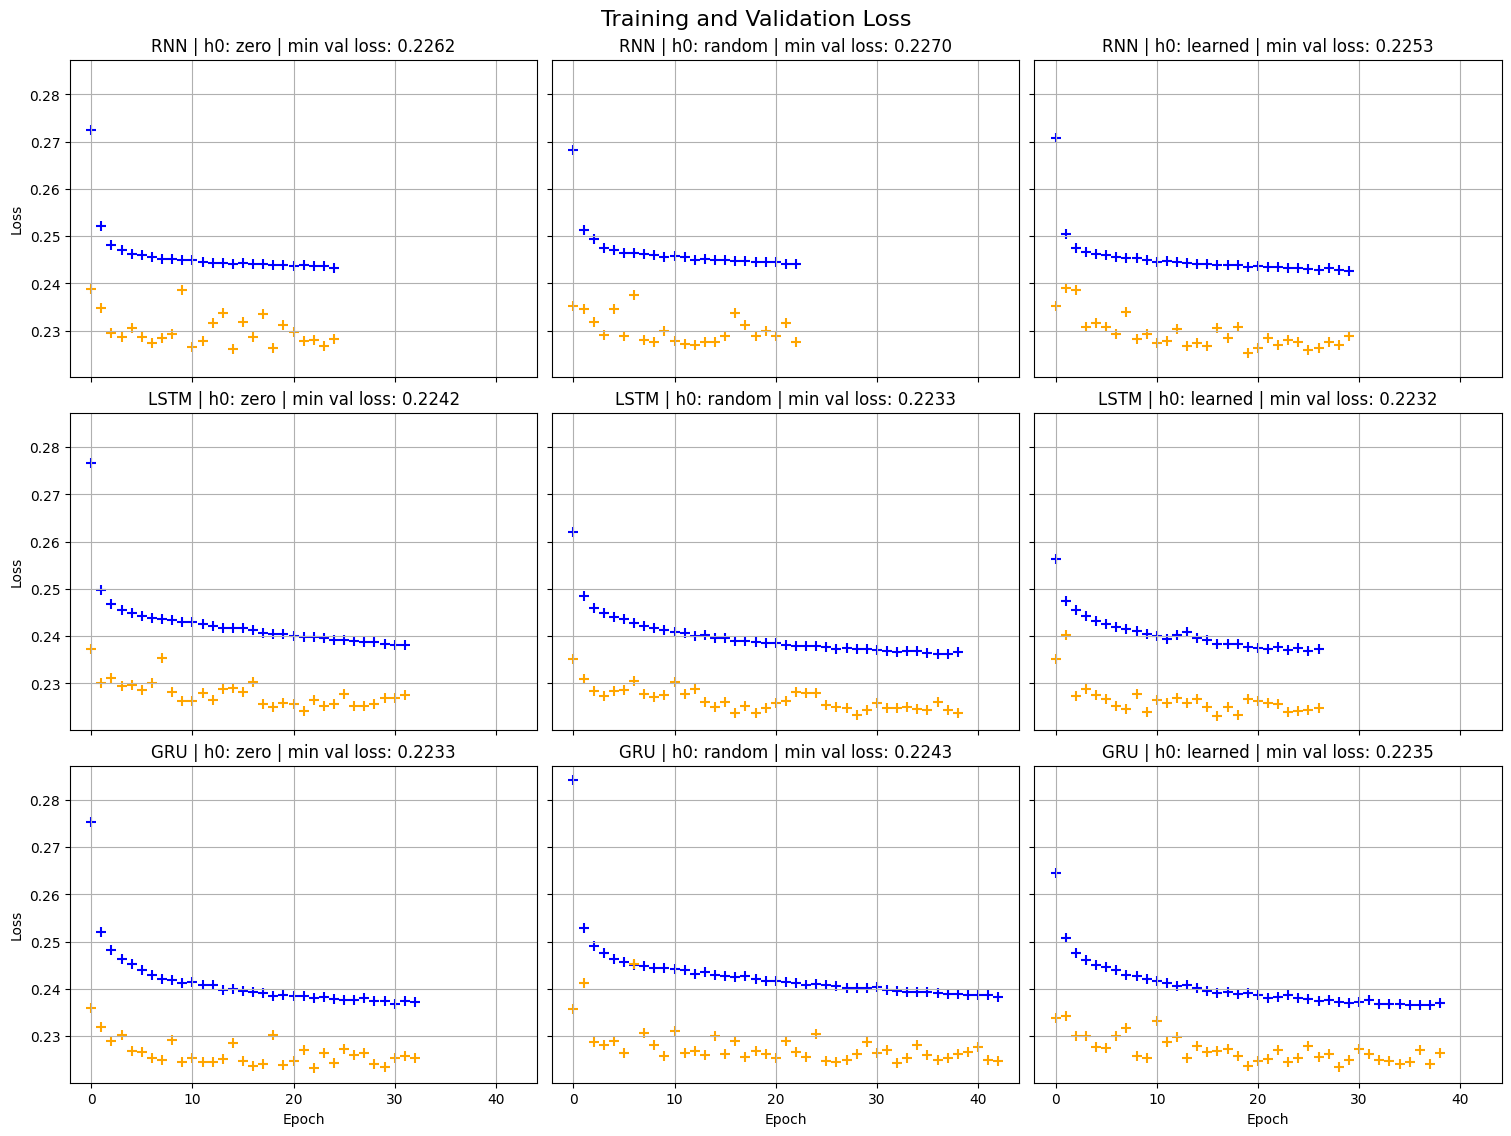

In [234]:
visualization.training_plots(results)

That might take some time to run. Let us save the results for later use:

In [235]:
import pickle

# with open("rnn_results.pkl", "wb") as f:
#     pickle.dump(results, f)

Then the results can be loaded using:

In [236]:
with open("rnn_results.pkl", "rb") as f:
    results = pickle.load(f)

train_loss and val_loss can be retrieved from the dictionary 'results' by doing:

In [237]:
results[("rnn","zero")]["val_loss"]

[tensor(0.2389, device='cuda:0'),
 tensor(0.2349, device='cuda:0'),
 tensor(0.2295, device='cuda:0'),
 tensor(0.2287, device='cuda:0'),
 tensor(0.2305, device='cuda:0'),
 tensor(0.2287, device='cuda:0'),
 tensor(0.2273, device='cuda:0'),
 tensor(0.2284, device='cuda:0'),
 tensor(0.2293, device='cuda:0'),
 tensor(0.2386, device='cuda:0'),
 tensor(0.2265, device='cuda:0'),
 tensor(0.2278, device='cuda:0'),
 tensor(0.2315, device='cuda:0'),
 tensor(0.2338, device='cuda:0'),
 tensor(0.2262, device='cuda:0'),
 tensor(0.2318, device='cuda:0'),
 tensor(0.2287, device='cuda:0'),
 tensor(0.2336, device='cuda:0'),
 tensor(0.2263, device='cuda:0'),
 tensor(0.2311, device='cuda:0'),
 tensor(0.2297, device='cuda:0'),
 tensor(0.2278, device='cuda:0'),
 tensor(0.2280, device='cuda:0'),
 tensor(0.2267, device='cuda:0'),
 tensor(0.2281, device='cuda:0')]

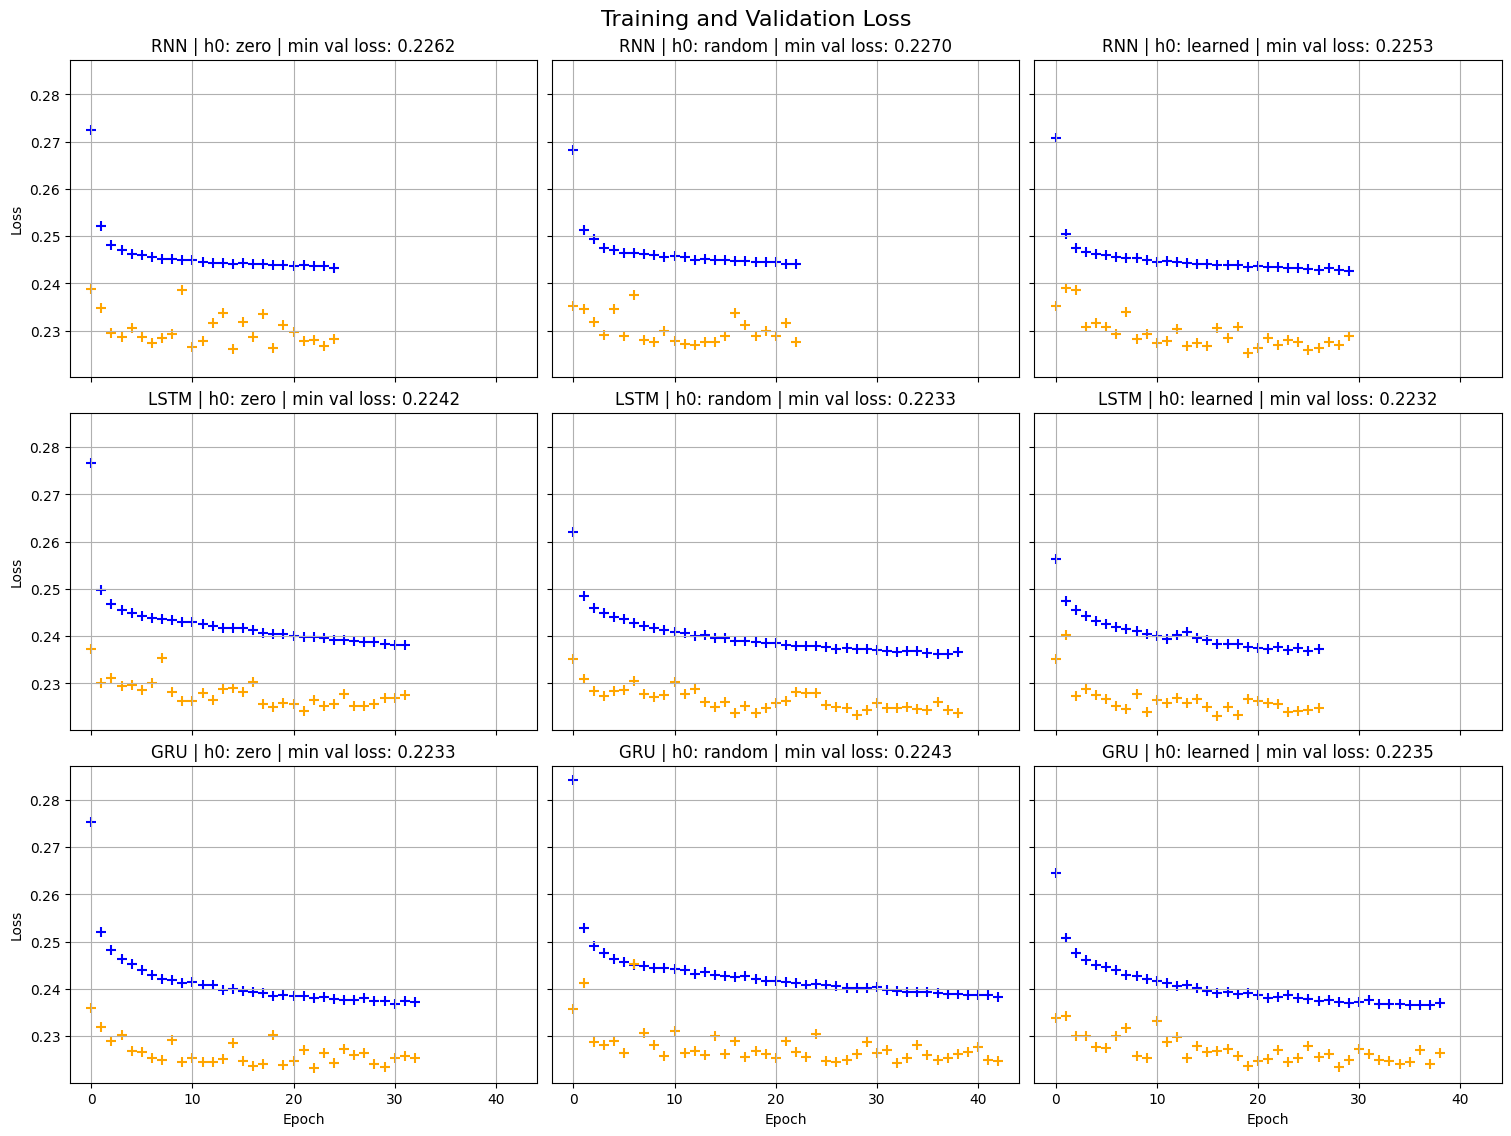

In [238]:
visualization.training_plots(results)

# The method of "adjustment value based on learned embedding" 

In this method, a learned embedding will embed the emb_id into a (normally 8) dim vector space, but instead of pre-appedning the vector in front of the time series, an adjustment_value will be trained based on the vector and multiplied with the rnn output trained based on the actual timeseries. Instead of offering initialization options, we will only use "learned" option in the following. 

In [24]:
sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

In [25]:
train_dataset.featureplace

{'sub_int_RV': (0, 60), 'emb_id': (60, 61)}

In [26]:
ts_place, id_place=train_dataset.featureplace["sub_int_RV"], train_dataset.featureplace["emb_id"]

In [27]:
ts_place

(0, 60)

In [28]:
id_place

(60, 61)

In [ ]:
# Create base rnn model interested: Let's try gru 

base_rnn_model=training.RV_RNN_conv(rnn_type="gru",rnn_drop_out=0,rnn_num_layer=1).to(device=device)

# Create the hidden learning layers post first learned embedding 

from collections import OrderedDict

id_hidden_dict=OrderedDict([("linear1", nn.Linear(in_features=8, out_features=1))])

id_hidden_layers=nn.Sequential(id_hidden_dict).to(device=device)

In [ ]:
# Create the combined model 

stock_adj_gru_model=training.id_learned_embedding_adj_rnn_mtpl(id_place=id_place, ts_place=ts_place,rnn_model=base_rnn_model,id_hidden_model=id_hidden_layers).to(device=device)

In [31]:
from torchinfo import summary
summary(stock_adj_gru_model)

Layer (type:depth-idx)                   Param #
id_learned_embedding_adj_rnn_mtpl        --
├─Embedding: 1-1                         896
├─RV_RNN_conv: 1-2                       --
│    └─frozen_diff_conv: 2-1             --
│    │    └─Conv1d: 3-1                  (2)
│    └─Linear: 2-2                       128
│    └─GRU: 2-3                          6,336
│    └─Linear: 2-4                       33
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       9
Total params: 7,404
Trainable params: 7,402
Non-trainable params: 2

In [32]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

import torch.optim as optim

optimizer = optim.Adam(stock_adj_gru_model.parameters(), lr=1e-3)

In [33]:
# Loss tracking
train_loss = []
val_loss = []

In [34]:
training.reg_training_loop_rmspe(optimizer=optimizer,model=stock_adj_gru_model,train_loader=train_loader,val_loader=test_loader,ot_steps=20,report_interval=5,n_epochs=200,list_train_loss=train_loss,list_val_loss=val_loss,device=device,eps=1e-6)

At  10.218531608581543  epoch  1 has training loss  tensor(0.4027, device='cuda:0')  and validation loss  tensor(0.2365, device='cuda:0') .

At  53.0471613407135  epoch  5 has training loss  tensor(0.2479, device='cuda:0')  and validation loss  tensor(0.2329, device='cuda:0') .

At  107.46643567085266  epoch  10 has training loss  tensor(0.2421, device='cuda:0')  and validation loss  tensor(0.2267, device='cuda:0') .

At  161.93251824378967  epoch  15 has training loss  tensor(0.2409, device='cuda:0')  and validation loss  tensor(0.2265, device='cuda:0') .

At  216.71730065345764  epoch  20 has training loss  tensor(0.2404, device='cuda:0')  and validation loss  tensor(0.2249, device='cuda:0') .

At  272.19612765312195  epoch  25 has training loss  tensor(0.2397, device='cuda:0')  and validation loss  tensor(0.2263, device='cuda:0') .

At  327.88794708251953  epoch  30 has training loss  tensor(0.2396, device='cuda:0')  and validation loss  tensor(0.2268, device='cuda:0') .

At  383.15

OrderedDict([('id_embeder.weight',
              tensor([[-3.1412e-01, -5.9118e-01, -1.9415e-01, -4.2031e-01,  8.1263e-01,
                        2.7685e-01, -4.4780e-01, -2.8401e-01],
                      [-3.5336e-03, -1.9686e+00, -6.0385e-01,  1.0189e+00, -2.7803e-01,
                       -5.0192e-01,  8.8526e-01,  1.5430e-01],
                      [-1.4450e-01,  5.1892e-01, -1.1455e-01,  1.1128e+00,  5.6945e-01,
                       -2.0339e+00,  2.4394e-02,  3.7719e-01],
                      [ 1.2383e-01, -7.5194e-01,  5.0231e-01, -4.9151e-02,  4.9315e-01,
                       -6.4209e-01, -6.1733e-02,  1.1401e-01],
                      [-1.1290e-01, -3.3603e-01, -1.1803e-01,  2.5691e-01,  2.8961e-01,
                        7.4365e-01,  7.8260e-01,  5.4268e-02],
                      [ 5.2999e-01, -2.6287e-01, -1.3695e-01, -1.3774e-01, -1.4970e-01,
                        1.4826e+00, -1.0519e+00, -5.4478e-02],
                      [-5.4348e-01, -9.1698e-02,  9.6758e-0

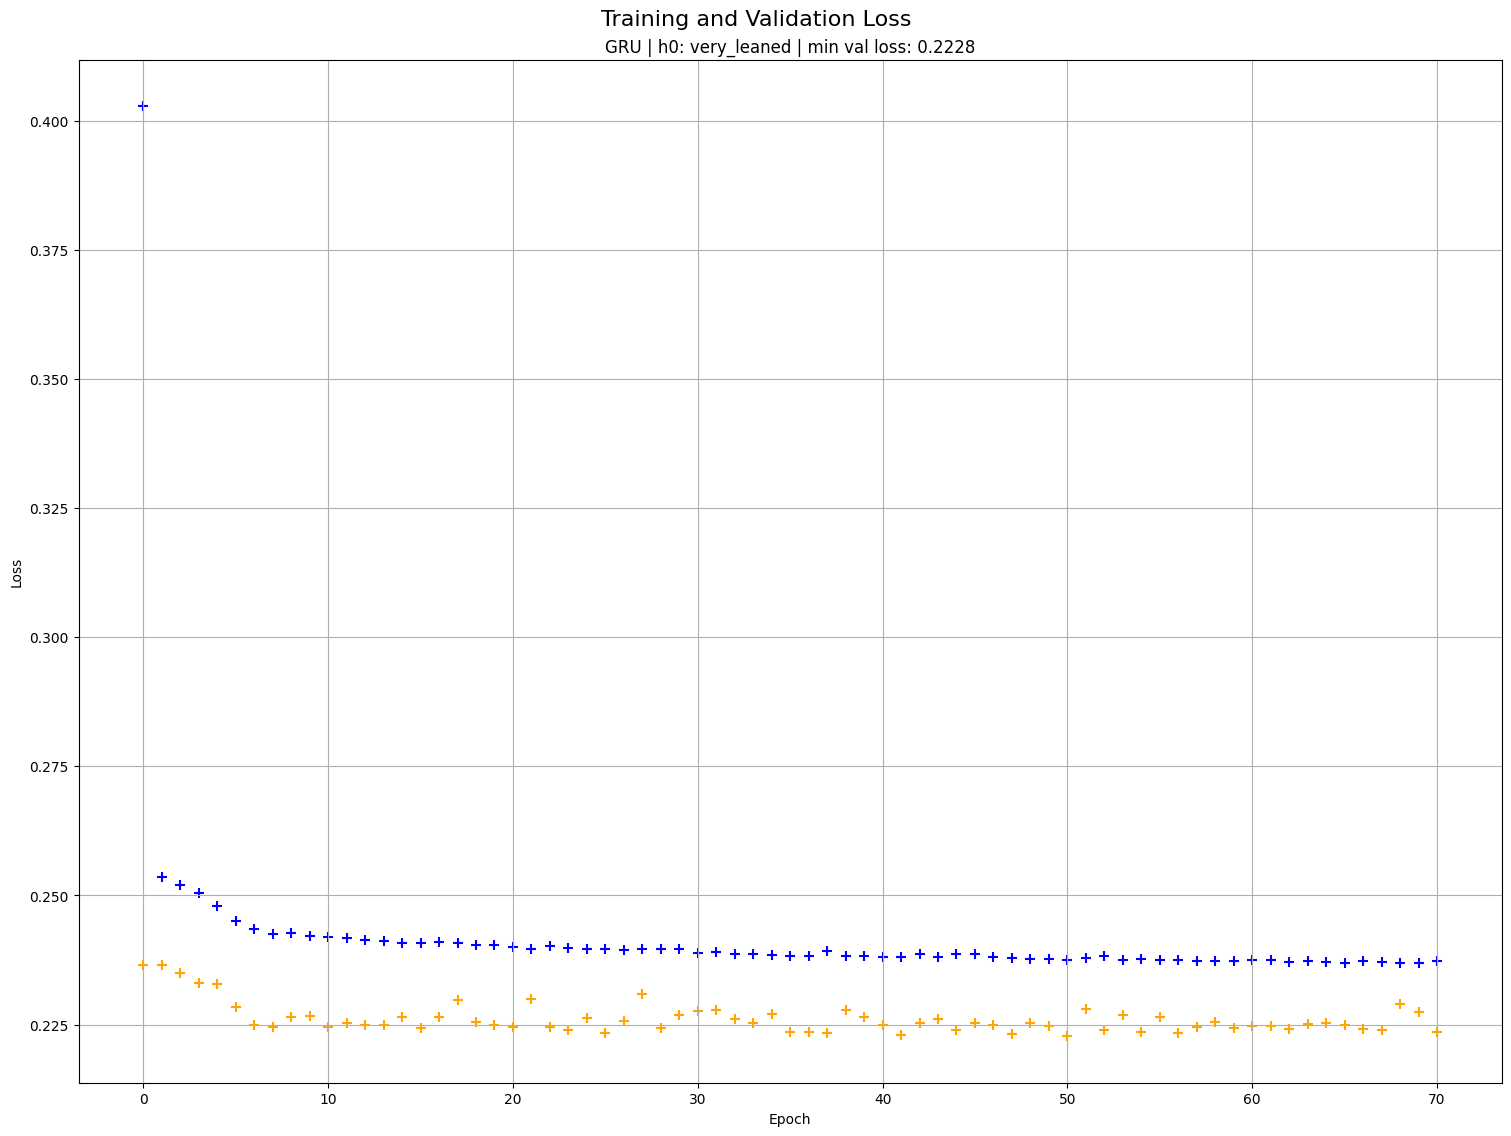

In [35]:
vis_dict={("gru","very_leaned"):{"train_loss": train_loss,"val_loss": val_loss}}
visualization.training_plots(vis_dict)

In [45]:
base_rnn_model=training.RV_RNN_conv(rnn_type="gru",rnn_drop_out=0,rnn_num_layer=1).to(device=device)

id_hidden_dict1=OrderedDict([("linear1", nn.Linear(in_features=8, out_features=32),),
                            ("tanh1", nn.Tanh()),
                            ("linear2", nn.Linear(in_features=32, out_features=16)),
                            ("tanh2", nn.Tanh()),
                            ("linear3", nn.Linear(in_features=16, out_features=8)),
                            ("tanh3", nn.Tanh()),
                            ("linear4", nn.Linear(in_features=8,out_features=1))])

id_hidden_layers1=nn.Sequential(id_hidden_dict1).to(device=device)

stock_adj_gru_model1=training.id_learned_embedding_adj_rnn_mtpl(id_place=id_place, ts_place=ts_place,rnn_model=base_rnn_model,id_hidden_model=id_hidden_layers1).to(device=device)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

import torch.optim as optim

optimizer = optim.Adam(stock_adj_gru_model1.parameters(), lr=1e-3)

# Loss tracking
train_loss = []
val_loss = []

In [46]:
from torchinfo import summary
summary(stock_adj_gru_model1)

Layer (type:depth-idx)                   Param #
id_learned_embedding_adj_rnn_mtpl        --
├─Embedding: 1-1                         896
├─RV_RNN_conv: 1-2                       --
│    └─frozen_diff_conv: 2-1             --
│    │    └─Conv1d: 3-1                  (2)
│    └─Linear: 2-2                       128
│    └─GRU: 2-3                          6,336
│    └─Linear: 2-4                       33
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       288
│    └─Tanh: 2-6                         --
│    └─Linear: 2-7                       528
│    └─Tanh: 2-8                         --
│    └─Linear: 2-9                       136
│    └─Tanh: 2-10                        --
│    └─Linear: 2-11                      9
Total params: 8,356
Trainable params: 8,354
Non-trainable params: 2

In [47]:
training.reg_training_loop_rmspe(optimizer=optimizer,model=stock_adj_gru_model1,train_loader=train_loader,val_loader=test_loader,ot_steps=20,report_interval=5,n_epochs=200,list_train_loss=train_loss,list_val_loss=val_loss,device=device,eps=1e-6)

At  10.87121057510376  epoch  1 has training loss  tensor(0.2708, device='cuda:0')  and validation loss  tensor(0.2295, device='cuda:0') .

At  56.8181676864624  epoch  5 has training loss  tensor(0.2448, device='cuda:0')  and validation loss  tensor(0.2297, device='cuda:0') .

At  114.0878369808197  epoch  10 has training loss  tensor(0.2423, device='cuda:0')  and validation loss  tensor(0.2248, device='cuda:0') .

At  171.54407691955566  epoch  15 has training loss  tensor(0.2412, device='cuda:0')  and validation loss  tensor(0.2254, device='cuda:0') .

At  228.7987415790558  epoch  20 has training loss  tensor(0.2405, device='cuda:0')  and validation loss  tensor(0.2239, device='cuda:0') .

At  287.2428045272827  epoch  25 has training loss  tensor(0.2399, device='cuda:0')  and validation loss  tensor(0.2241, device='cuda:0') .

At  344.1899745464325  epoch  30 has training loss  tensor(0.2395, device='cuda:0')  and validation loss  tensor(0.2257, device='cuda:0') .

At  401.1840653

OrderedDict([('id_embeder.weight',
              tensor([[ 1.9161e-01,  2.0398e+00,  6.1925e-01, -4.8663e-01,  3.0746e-01,
                       -1.4225e+00,  8.0833e-01,  3.2490e-01],
                      [ 2.2426e+00,  8.7686e-01, -3.7663e-01,  1.3633e-02,  5.3291e-01,
                        3.4291e-01, -1.4207e+00,  6.0810e-01],
                      [ 9.6258e-01,  3.5393e-01, -5.5708e-01,  9.9023e-01, -1.2703e+00,
                       -3.9169e-02,  9.5263e-01,  8.0369e-01],
                      [ 2.0068e+00,  4.6727e-01,  1.4393e+00, -8.8920e-01,  9.4537e-02,
                       -6.4346e-01,  2.4267e-01,  2.6911e+00],
                      [-5.9462e-01, -1.7275e+00,  3.3641e-01,  4.8766e-01, -1.3616e+00,
                        4.0541e-01, -1.4054e+00, -4.0409e-01],
                      [ 6.4311e-01,  3.2230e-01, -1.1171e+00,  7.0557e-01, -3.2265e-01,
                        3.4972e-01,  5.3014e-01,  1.2185e+00],
                      [ 3.0388e-01,  2.1317e-01, -2.2943e-0

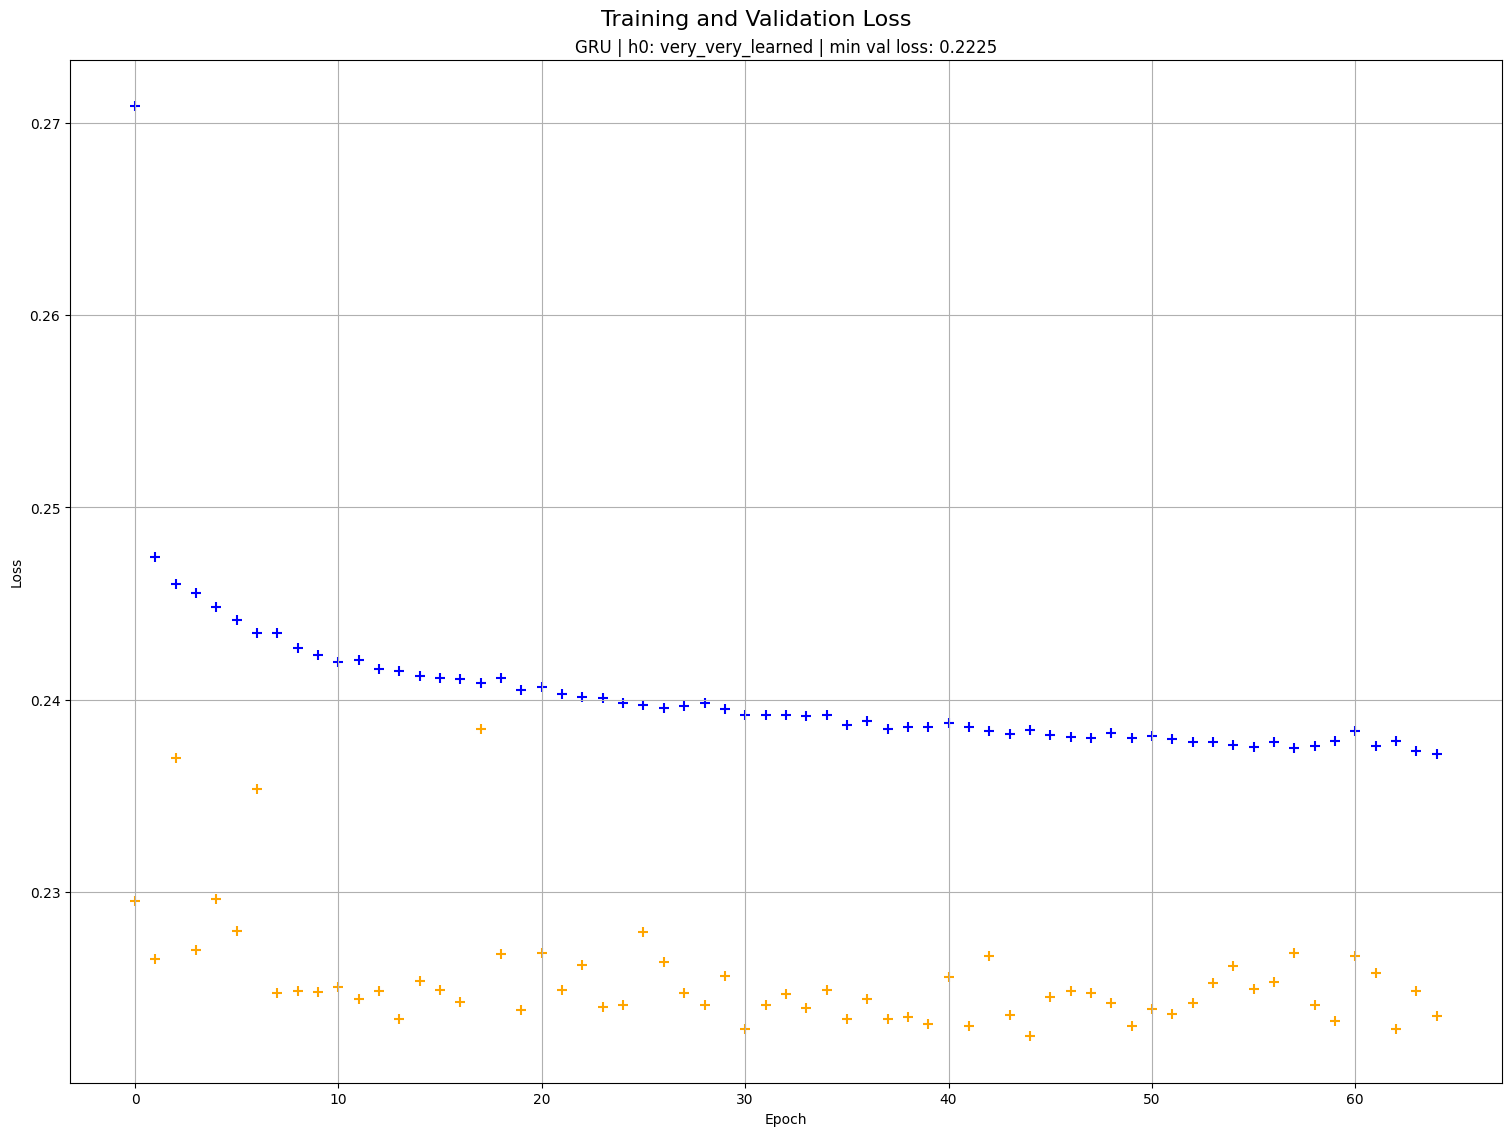

In [48]:
vis_dict={("gru","very_very_learned"):{"train_loss": train_loss,"val_loss": val_loss}}
visualization.training_plots(vis_dict)